## Challenge


## Solution: Survival Analysis

I considered this to be a survival analysis problem where the idea to predict the time to a certain event such as death, divorce etc. The 'event' in this case is resignation from an employment position. 

In [22]:
#Importations
import pandas as pd
import numpy as np
from scipy import stats
from lifelines.estimation import KaplanMeierFitter

# Plotting helpers
from IPython.display import HTML
%matplotlib inline
import matplotlib.pyplot as plt

import datetime

In [62]:
#Variables
global_start_date = datetime.datetime.strptime('2011/01/24', '%Y/%m/%d')
global_end_date = datetime.datetime.strptime('2015/12/13', '%Y/%m/%d')

### Read the data and calculate the time in days  before quit
I append two extra columns to the data. 
Time : Time in days before they quit or as of 2015/12/13 if they are still with the employer.
Observed_Quit: Boolean where 1 shows that we have observed the resignation event and 0 shows that we haven't
##### Essentially 0 denotes right-censored individuals whose resignation has not been observed.


In [69]:
data = pd.read_csv('employee_retention_data.csv')
def date_convert(date):
    try:
        return datetime.datetime.strptime(date, '%Y-%m-%d')
    except:
        return -1

def calculate_T(dates):
    quitdate = dates[0]
    joindate = dates[1]
    quit = date_convert(quitdate)
    join = date_convert(joindate)    
    try:
        # Calculate how many days they were in the company before they quit.
        #Return a 1 as well to show that we have observed the event of leaving the company
        return (quit-join).days,1 
    except:
        #This is the group with NaN at the quit date that is still assumed to be with the company
        #Return a 0 to show that we have not observed the event of leaving the company
        return (global_end_date-join).days,0 

calculate_times  = list(map(calculate_T,zip(data['quit_date'],data['join_date'])))
data['Time'] = list(map(lambda x: x[0],calculate_times))
data['Observed_Quit']= list(map(lambda x: x[1],calculate_times))
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,Time,Observed_Quit
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585,1
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,426,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040,1


#### Perform survival analysis using Kaplan-Meier

In [73]:
T = data['Time'] 
E = data['Observed_Quit']
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E) # more succiently, kmf.fit(T,E)

<lifelines.KaplanMeierFitter: fitted with 24702 observations, 11192 censored>

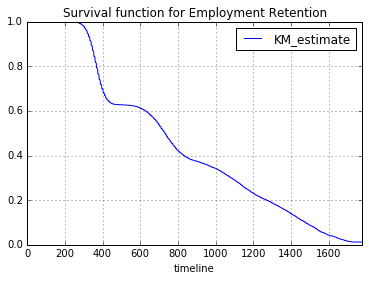

In [93]:
kmf.survival_function_.plot(ax=plt.subplot(111))
plt.title('Survival function for Employment Retention')
plt.grid()

In [77]:
kmf.median_

732.0

Median time at which approximately half of the employees have left is: 
##### 2 years  (~732 days )
We can also infer the following from the graph above:
###### First 9 months (~280 days): -Most people stay in their respective companies 
###### 9-12 months (~280-400 days): -Sharp drop where most companies lose a lot of employees as survival drops to around 60%
###### 13-20 months (~400-600 days): -Fairly flat where the survival rate doesn't drop much.
###### 20-27 months (~600-800 days): -Another sharp drop where survival drops to 40%
###### 800 days onwards: -Survival drops steadily until almost noone is left after four and a half years


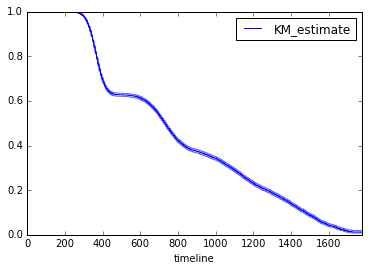

In [90]:
# Plot incorporating confidence interval to see how uncertain we are about our results
kmf.plot(ci_force_lines=True)

In [82]:
print(data['company_id'].unique())

[ 7  4  2  9  1  6 10  5  3  8 11 12]


In [92]:
groups = data.groupby('company_id')
# for c in groups:
# groups.get_group(1)

#### Plot the survival function for all companies

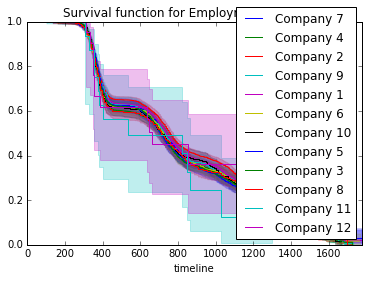

In [105]:
allcompanies = data['company_id'].unique()
ax = plt.subplot(111)

for x in allcompanies:
    comp = groups.get_group(x)
    kmf.fit(comp['Time'], event_observed=comp['Observed_Quit'], label="Company "+str(x))
    kmf.plot(ax=ax )

plt.ylim(0,1);
plt.title("Survival function for Employment Retention");
plt.legend(loc = 0)


Plot each company separately

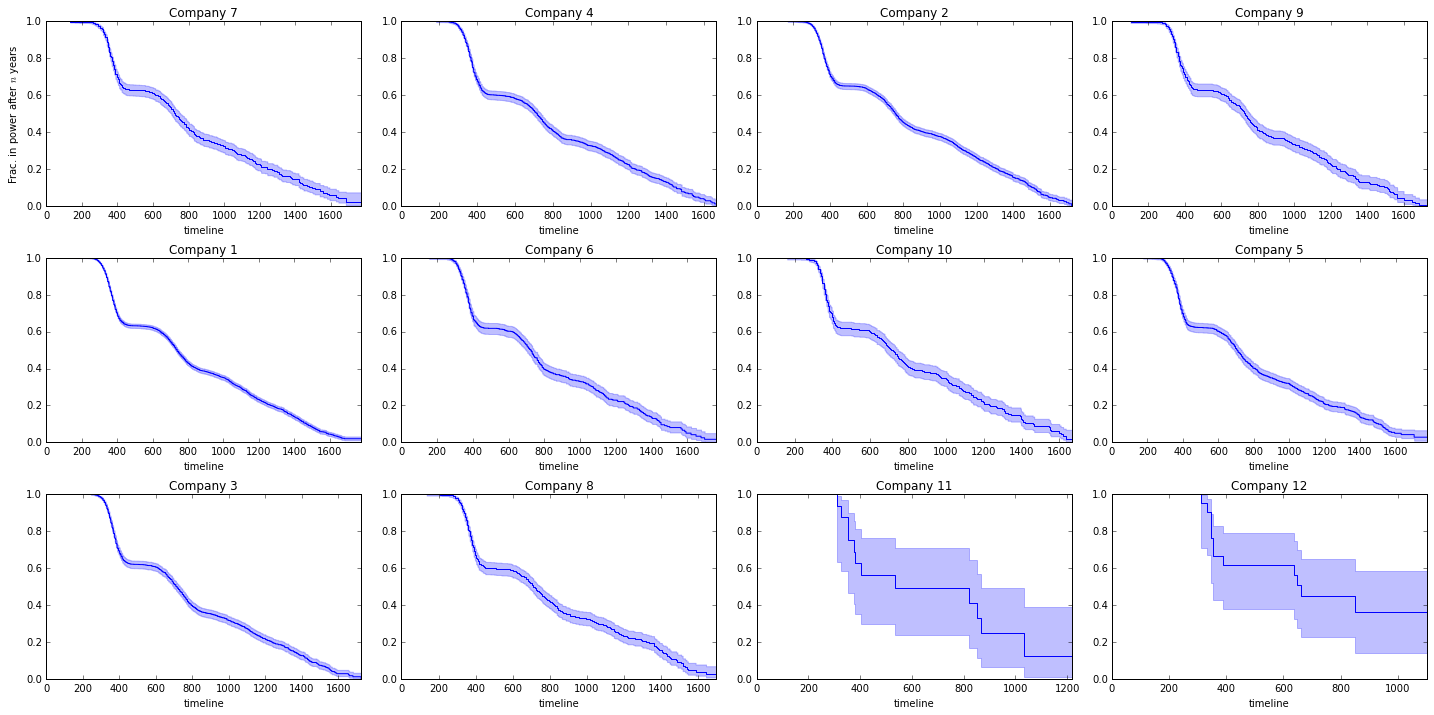

In [138]:
fig = plt.figure(figsize=(20, 10))

for i,x in  enumerate(allcompanies):
    ax = fig.add_subplot(3, 4, i+1)
    ax.set_figure
    comp = groups.get_group(x)
    kmf.fit(comp['Time'], event_observed=comp['Observed_Quit'], label="Company "+str(x))
    kmf.plot(ax=ax, legend=False)
    plt.title("Company "+str(x));
    plt.ylim(0,1);
    if i==0:
        plt.ylabel('Frac. in power after $n$ years')
plt.tight_layout()
plt.figure(figsize=(12,10)) 

Companies 11 and 12 seem to be having different survival functions with a wider range of uncertainity. Most of the other companies seem to have the same trendline.

#### Plot the survival function by department

In [108]:
data['dept'].unique()

array(['customer_service', 'marketing', 'data_science', 'engineer',
       'sales', 'design'], dtype=object)

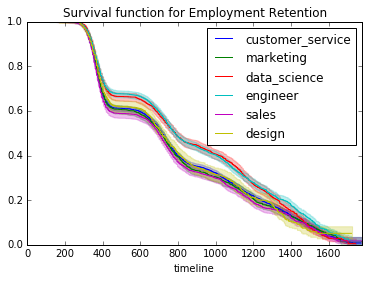

In [112]:
grouped_deps = data.groupby('dept')
deps = data['dept'].unique()
ax = plt.subplot(111)

for x in deps:
    comp = grouped_deps.get_group(x)
    kmf.fit(comp['Time'], event_observed=comp['Observed_Quit'], label=str(x))
    kmf.plot(ax=ax )

plt.ylim(0,1);
plt.title("Survival function for Employment Retention");
plt.legend(loc = 0)

Employees indifferent department also seem to have the same survival trend line when it comes to churn.

Assume, for each company, that the headcount starts from zero on 2011/01/23. 
Estimateemployee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13.
That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have
already quit, then company headcount on 2012/03/02 for company 1 would be 1000.
You should create a table with 3 columns: day, employee_headcount, company_id.